In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pprint

import clu.checkpoint
import jax
import jax.numpy as jnp
import tensorflow as tf
import sqlalchemy as sa
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd
import matplotlib.pyplot as plt

from userdiffusion import samplers, unet
from userfm import cs, datasets, diffusion, sde_diffusion, utils

2025-01-07 19:04:00.214354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736276640.232390    9117 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736276640.237840    9117 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# somehow, this line of code presents a segmentation fault in nn.Dense
# when calling model.init
tf.config.experimental.set_visible_devices([], 'GPU')

In [4]:
# Diffusion Models
config_alt_id = 'tuf7pmkx'  # c = 4
# config_alt_id = ''  # c = 8
# config_alt_id = ''  # c = 16
# config_alt_id = ''  # c = 32
# config_alt_id = ''  # c = 64

# Flow Matching
# config_alt_id = ''  # c = 4
# config_alt_id = ''  # c = 8
# config_alt_id = ''  # c = 16
# config_alt_id = ''  # c = 32
# config_alt_id = ''  # c = 64

In [5]:
engine = cs.get_engine()
cs.create_all(engine)
with cs.orm.Session(engine) as session:
    cfg = session.execute(sa.select(cs.Config).where(cs.Config.alt_id == config_alt_id)).first()[0]
    # cfg_model = cs.detach_config_from_session(type(cfg.model), cfg.model.id, session)
    pprint.pp(cfg)

    key = jax.random.key(cfg.rng_seed)
    key, key_dataset = jax.random.split(key)

    # cfg.dataset.time_step_count = 1_000
    ds = datasets.get_dataset(cfg.dataset, key=key_dataset)

    cfg_unet = unet.unet_64_config(
        1,
        base_channels=cfg.model.architecture.base_channel_count,
        attention=cfg.model.architecture.attention,
    )
    model = unet.UNet(cfg_unet)
    # just create params, restore saved weights later
    params = model.init(
        jax.random.key(42),
        x=ds.Zs[:cfg.dataset.batch_size],
        t=jax.random.uniform(jax.random.key(0), cfg.dataset.batch_size),
        train=False,
        cond=None,
    )
    ckpt = clu.checkpoint.MultihostCheckpoint(str(cfg.run_dir/'model-checkpoints'), {}, max_to_keep=2)
    ema_params = ckpt.restore(params)

Config(root_dir='/root/workspace/GitHub/pmlr-v202-finzi23a',
       src_dir='/root/workspace/GitHub/pmlr-v202-finzi23a/userdiffusion/src',
       out_dir='/root/workspace/out/diffusion-dynamics/pmlr-v202-finzi23a',
       prediction_filename='prediction.pt',
       device='cuda',
       id=18,
       alt_id='tuf7pmkx',
       rng_seed=42,
       fit=True,
       predict=False,
       model=ModelDiffusion(id=4,
                            architecture=UNet(id=2,
                                              epochs=10000,
                                              learning_rate=0.0001,
                                              base_channel_count=4,
                                              attention=False),
                            sde_diffusion=SDEVarianceExploding(id=1,
                                                               time_min=0.001,
                                                               time_max=1.0,
                                                 

Dataset Samples


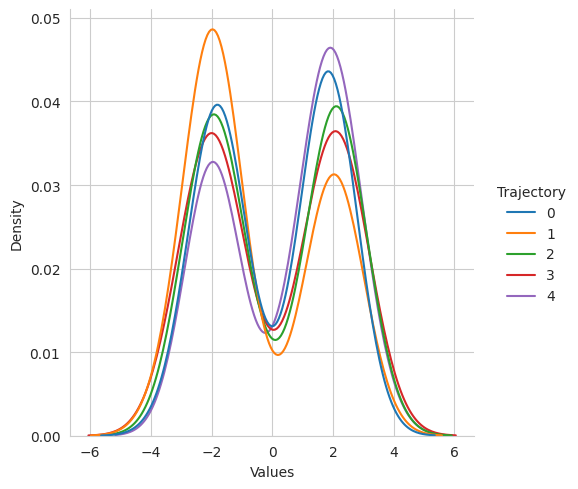

In [6]:
df = pd.concat([
    pd.DataFrame(dict(
        Trajectory=str(i), Values=ds.Zs[cfg.dataset.batch_size:][i, :, 0],
    ))
    for i in range(5)
])
df = df.reset_index(names='Time Step')
plot = (
    sns.displot(
        kind='kde',
        data=df,
        x='Values',
        hue='Trajectory',
    )
)
print('Dataset Samples')

Dataset Samples


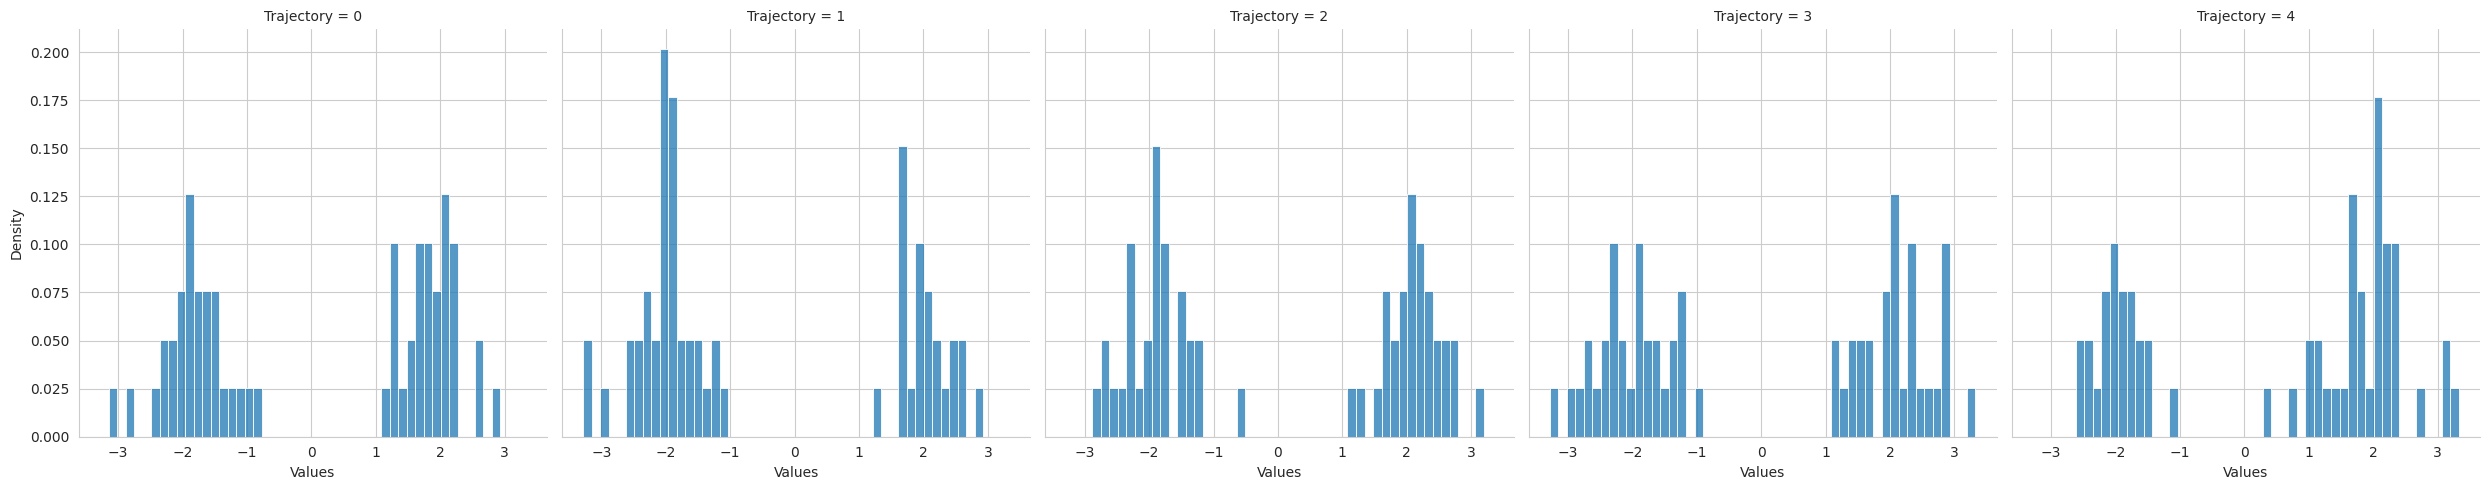

In [7]:
plot = (
    sns.displot(
        kind='hist',
        stat='density',
        data=df,
        x='Values',
        col='Trajectory',
        bins=50,
    )
)
print('Dataset Samples')

In [8]:
data_std = ds.Zs[cfg.dataset.batch_size:].std()
data_std

Array(2.057279, dtype=float32)

In [9]:
@jax.jit
def score(x, t, cond=None):
    if not hasattr(t, 'shape') or not t.shape:
        t = jnp.ones(x.shape[0]) * t
    return diffusion.score(model, ema_params, difftype, data_std, x, t, train=False, cond=cond)

In [10]:
@jax.jit
def velocity(x, t, cond=None):
    if not hasattr(t, 'shape') or not t.shape:
        t = jnp.ones(x.shape[0]) * t
    return model.apply(ema_params, x=x, t=t, train=False, cond=cond)

In [11]:
trajectory_count = 10
key, key_samples = jax.random.split(key)
if isinstance(cfg.model, cs.ModelDiffusion):
    difftype = sde_diffusion.get_sde_diffusion(cfg.model.sde_diffusion)
    samples = samplers.sde_sample(difftype, score, key_samples, x_shape=ds.Zs[:trajectory_count].shape, nsteps=1_000, traj=True)
elif isinstance(cfg.model, cs.ModelFlowMatching):
    samples = samplers.ode_sample_taos(velocity, 1., key_samples, x_shape=ds.Zs[:trajectory_count].shape, nsteps=1_000, traj=True)
else:
    raise ValueError(f'Unknown model: {cfg.model}')

Model Samples


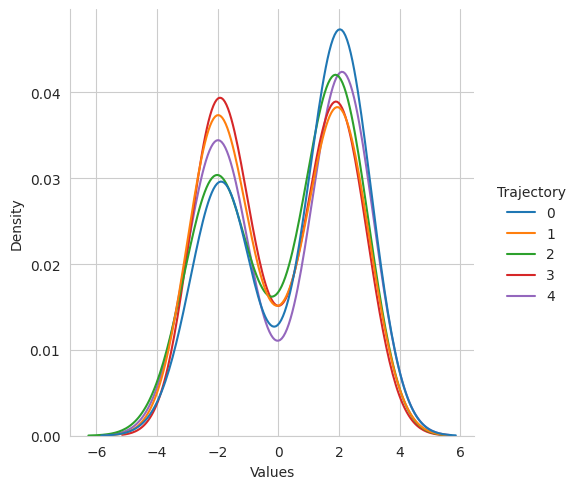

In [12]:
df = pd.concat([
    pd.DataFrame(dict(
        Trajectory=str(i), Values=samples[-1, i, :, 0],
    ))
    for i in range(5)
])
df = df.reset_index(names='Time Step')
plot = sns.displot(
    kind='kde',
    data=df,
    x='Values',
    hue='Trajectory',
)
print('Model Samples')

Model Samples


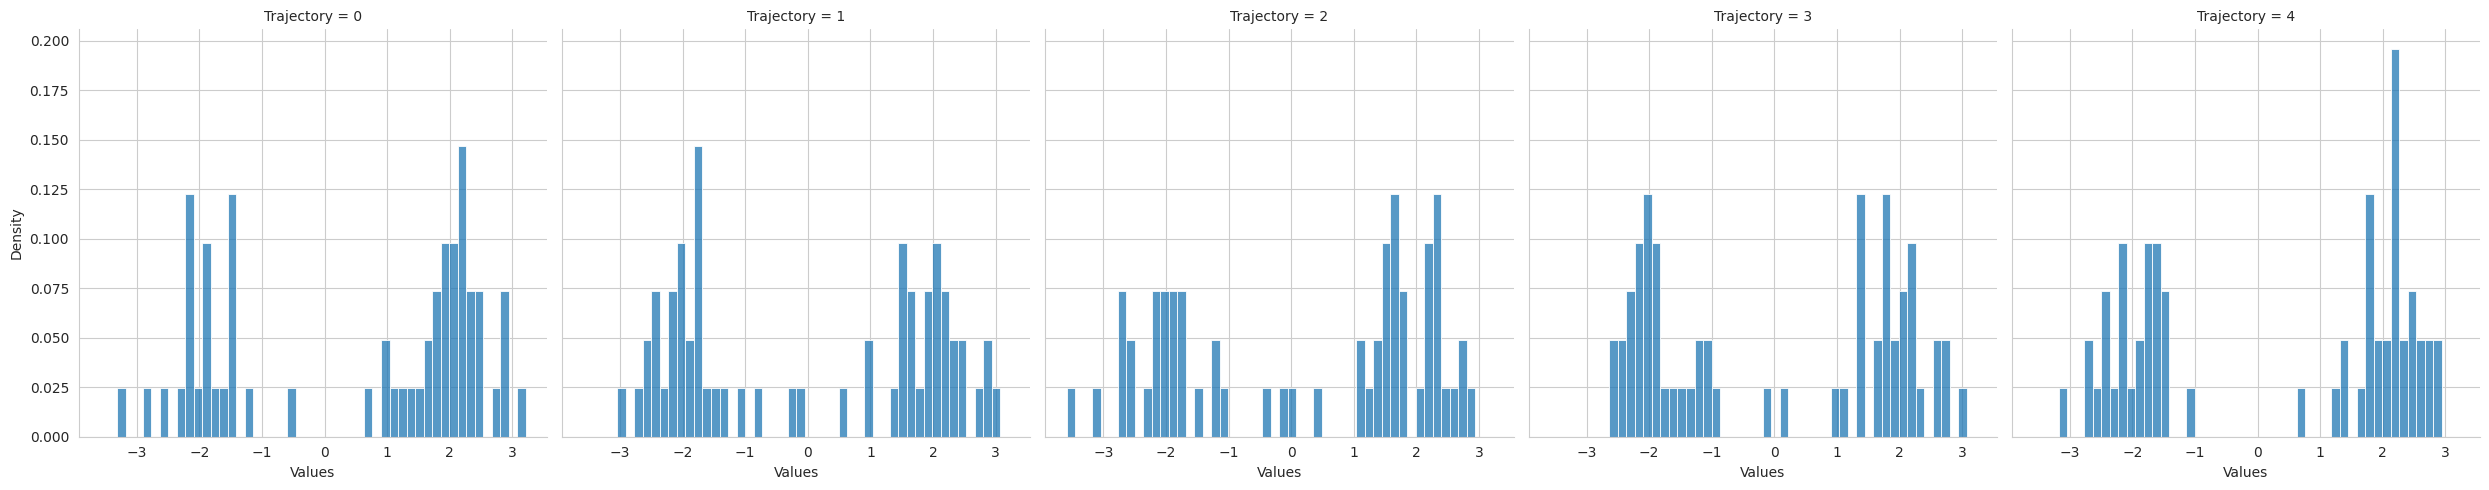

In [13]:
plot = sns.displot(
    kind='hist',
    stat='density',
    data=df,
    x='Values',
    col='Trajectory',
    bins=50,
)
print('Model Samples')

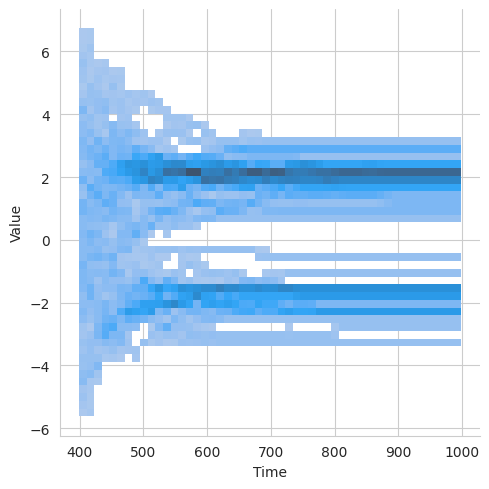

In [14]:
df = (
    pd.DataFrame(samples[:, 0, :, 0])
    .iloc[-600:]
    .T
    .melt(var_name='Time', value_name='Value')
)
plot = sns.displot(data=df, x='Time', y='Value', bins=50)